## Train and stores embeddings

this colab loads a the code from git, trains GMM/GVAE model and stores the embeddings for further analysis



In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
#@title Set up and imports
from google.colab import drive 
import os 

import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras.engine import node
from tensorflow.python.keras.engine.node import Node 
import tensorflow_probability as tfp
tfd = tfp.distributions

import numpy as np
import scipy.sparse as sp

# notebook's location in the repo
WORKING_PATH = './drive/MyDrive/GGMbetaFactorVAE/GVAE/' 

if 'first_run' not in locals():
  drive.mount('/content/drive/')
  os.chdir(WORKING_PATH)

  first_run = False

In [15]:
from src.models import GM_VGAE, VGAE
from src import utils 

## Loading data 

In [17]:
## Loads data

network_path = 'data/diseasome/disease_network_adj.npy'
labels_path = 'data/diseasome/disease_network_types.npy'
output_path = 'data/saved/diseasome/model/'

data_params = dict(network_path=network_path,
                   labels_path=labels_path,
                   use_features=False,
                   auxiliary_prediction_task=True,
                   epochs=1000)

res = utils.load_and_build_dataset(data_params)
adj = res['adj']
aux_targets = res['target']
dataset = res['dataset']
val_edges = res['val_edges']
val_edges_false = res['val_edges_false']
test_edges = res['test_edges']
test_edges_false = ['test_edges_false']

adj_orig = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
adj_orig.eliminate_zeros()
adj_orig = adj_orig.toarray()

DONE: train_edges
DONE: test_edges_false
DONE: val_edges_false
True
True
True
True
True


## Defining a train step

In [18]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score


def get_roc_score(edges_pos, edges_neg, emb):

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]]))
        pos.append(adj_orig[e[0], e[1]])

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]]))
        neg.append(adj_orig[e[0], e[1]])

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score

In [19]:

def train_step(adj_normalized, features, adj_label, norm, pos_weight, experiment_params, aux_targets=None):   
    """ Defines basic training step """

    model_type = experiment_params['model']
    assert model_type in ['VGAE', 'GM_VGAE']
    assert ((model_type=='VGAE' and aux_targets is None) or (model_type=='GM_VGAE'))

    with tf.GradientTape() as tape:
        beta = 1
        adj_label = tf.reshape(adj_label, [-1])

        Q, Q_log_std, reconstructed = model(adj_normalized, features)
        reconstruction_loss = norm * tf.math.reduce_mean(
            tf.nn.weighted_cross_entropy_with_logits(labels=adj_label, logits=reconstructed, pos_weight=pos_weight)
        ) 
        node_num = adj_normalized.shape[0] 
        if model_type == 'VGAE':
            # kl = - (0.5 / node_num) * tf.math.reduce_mean(
            #     tf.math.reduce_sum(1 + 2 * Q_log_std - tf.math.square(Q.mean()) - tf.math.square(Q.stddev()), axis=1)
            # ) 

            kl = tf.reduce_mean(tfd.kl_divergence(Q, model.prior)) / node_num
            classification_loss = 0
        else:
            kl = tf.reduce_mean(utils.mc_kl_divergence(Q, model.prior)) / node_num
            # kl = tf.reduce_mean(kl_divergence_upper_bound(Q, model.prior)) / node_num

            if experiment_params['auxiliary_prediction_task']:
                classification_loss = tf.reduce_mean(
                    tf.nn.softmax_cross_entropy_with_logits(logits=model.cy_logits, labels=aux_targets)
                )
                classification_accuracy = tf.reduce_mean(
                    tf.cast(tf.argmax(model.cy_logits, axis=1)==tf.argmax(aux_targets, axis=1), tf.float32), axis=0
                )
            else: 
                classification_loss = 0
                classification_accuracy = None
        
        vae_loss = reconstruction_loss + beta*kl + classification_loss

    gradients = tape.gradient(vae_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # metrics
    RECONSTRUCTION.append(reconstruction_loss.numpy())
    KL_LOSSES.append(kl.numpy())
    LOSSES.append(vae_loss.numpy())
    if experiment_params['auxiliary_prediction_task']:
        CLASSIFICATION_LOSSES.append(classification_loss.numpy())
        CLASSIFICATION_ACCURACIES.append(classification_accuracy.numpy())

    if experiment_params['model'] == 'GM_VGAE':
        # taking the mean of the mixture doesn't work in this case.
        # NOTE we could approximate the mean 
        emb = tf.squeeze(Q.sample(1), axis=0).numpy() 
    else: 
        emb = Q.mean().numpy()

    roc_curr, ap_curr = get_roc_score(val_edges, val_edges_false, emb)
    VAL_ROC_SCORE.append(roc_curr)
    VAL_AP_SCORE.append(ap_curr)
    

## Experiment 

In [20]:
def experiment_name(experiment_params, dataset):
    assert dataset=='diseasome' or dataset=='debarmentnetwork'
    aux_task = 'aux' if experiment_params['auxiliary_prediction_task'] else 'noaux'
    features = 'features' if experiment_params['use_features'] else 'nofeatures'
    return dataset + '_'\
                + experiment_params['model'] + '_'\
                + str(experiment_params['latent_size']) + '-'\
                +aux_task + '_'\
                +features + '_'\
                +str(experiment_params['epochs'])

def save_experiment(experiment_params, dataset, model, fig): 
    assert dataset=='diseasome' or dataset=='debarmentnetwork'
    name = experiment_name(experiment_params, dataset) 
    save_path = './data/saved/'+name+'/'
    os.mkdir(save_path)
    model_path = save_path + '/model/'
    os.mkdir(model_path)
    model.save_weights(model_path)     
    fig.savefig(save_path+'diagnostics.jpg')
    
    

In [21]:
## Initializes experiment 

experiment_params = dict(
    learning_rate=1e-3,
    epochs=data_params['epochs'],
    hidden=32,
    latent_size=16,
    dropout=0.2 ,
    model='GM_VGAE',
    # model='VGAE',
    use_features=data_params['use_features'],      
    auxiliary_prediction_task=data_params['auxiliary_prediction_task'],
    save_path=output_path 
)

# auxiliary prediction can only be done with GM_VAE
assert not (experiment_params['model']=='VGAE' and experiment_params['auxiliary_prediction_task'])

    
optimizer = tf.keras.optimizers.Adam(learning_rate=experiment_params['learning_rate'])
RECONSTRUCTION = []
KL_LOSSES = []
LOSSES = []
CLASSIFICATION_LOSSES = []
CLASSIFICATION_ACCURACIES = []
VAL_ROC_SCORE = []
VAL_AP_SCORE = []

pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)


class_num = aux_targets.shape[1]
node_num = adj.shape[0]

if experiment_params['model'] == 'VGAE':
    model = VGAE(node_num=node_num, 
                  hidden=experiment_params['hidden'], 
                  latent_size=experiment_params['latent_size'],
                  dropout=experiment_params['dropout'])
elif experiment_params['model'] == 'GM_VGAE':
    model = GM_VGAE(node_num=node_num, 
                    class_num=class_num, 
                    latent_size=experiment_params['latent_size'],
                    hidden=experiment_params['hidden'],
                    dropout=experiment_params['dropout'])


In [22]:
#@title Training loop

e = 0
for adj_norm, features, label in dataset:
    if experiment_params['model'] == 'GM_VGAE':
        train_step(adj_norm, features, 
                label, norm, pos_weight, 
                experiment_params, aux_targets=aux_targets)
    else:
         train_step(adj_norm, features, 
                label, norm, pos_weight, 
                experiment_params)
    
    if e % 100 == 0:
        if experiment_params['auxiliary_prediction_task']:
            print(
                'total: {:.2f}, rec: {:.2f}, classification: {:.2f}, kl_loss: {:.2f}'.format(
                LOSSES[-1], RECONSTRUCTION[-1], CLASSIFICATION_ACCURACIES[-1], KL_LOSSES[-1]))
        else:
            print('total: {:.2f}, rec: {:.2f}, kl_loss: {:.2f}'.format(
                LOSSES[-1], RECONSTRUCTION[-1], KL_LOSSES[-1]))

    e +=1

# test_roc, test_ap = get_roc_score(test_edges, test_edges_false, )

total: 4.84, rec: 1.75, classification: 0.03, kl_loss: 0.00
total: 4.20, rec: 1.35, classification: 0.50, kl_loss: 0.00
total: 3.09, rec: 0.81, classification: 0.52, kl_loss: 0.01
total: 2.45, rec: 0.68, classification: 0.65, kl_loss: 0.02
total: 1.97, rec: 0.58, classification: 0.70, kl_loss: 0.03
total: 1.66, rec: 0.53, classification: 0.74, kl_loss: 0.03
total: 1.44, rec: 0.49, classification: 0.76, kl_loss: 0.04
total: 1.28, rec: 0.48, classification: 0.77, kl_loss: 0.04
total: 1.15, rec: 0.45, classification: 0.81, kl_loss: 0.04
total: 1.05, rec: 0.44, classification: 0.83, kl_loss: 0.04


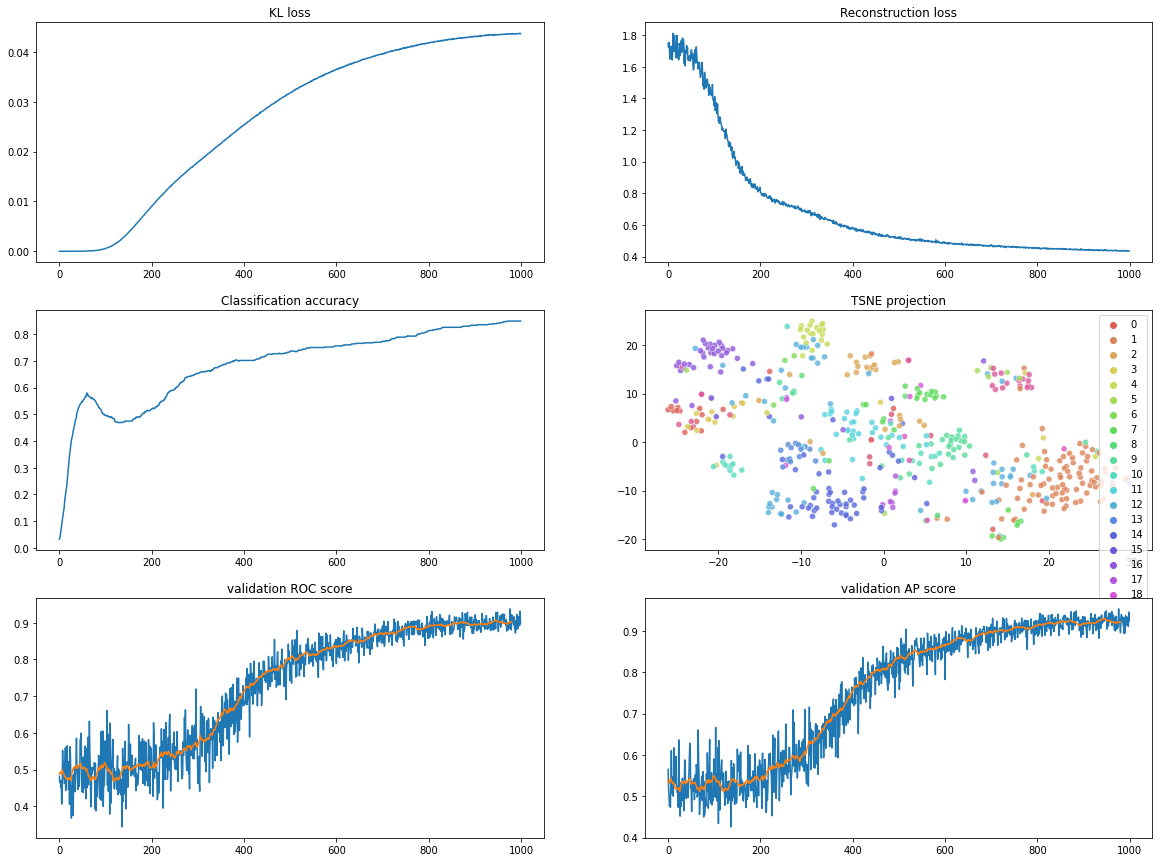

In [23]:
#@title Diagnosis plots - 
#@markdown 

import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.manifold import TSNE
import numpy as np


Q = model.Q
z = tf.squeeze(Q.sample(1))
    
z_proj = TSNE(n_components=2).fit_transform(z)
    

fig, axs = plt.subplots(3, 2, figsize=(20, 15))
axs = axs.flatten()

axs[0].plot(KL_LOSSES)
axs[0].set_title('KL loss')

axs[1].plot(RECONSTRUCTION)
axs[1].set_title('Reconstruction loss')

if experiment_params['auxiliary_prediction_task']:
    # axs[2].plot(CLASSIFICATION_LOSSES)
    # axs[2].set_title('Classification loss')

    axs[2].plot(CLASSIFICATION_ACCURACIES)
    axs[2].set_title('Classification accuracy')

if 'z_proj' in locals():
    # if experiment_params['auxiliary_prediction_task']:
    sns.scatterplot(
        x=z_proj[:, 0], y=z_proj[:, 1],
        palette=sns.color_palette("hls", aux_targets.shape[1]),
        hue=np.where(aux_targets==1)[1],
        legend='full', 
        alpha=0.8,
        ax=axs[3]
    )
    # else:
    #     sns.scatterplot(
    #         x=z_proj[:, 0], y=z_proj[:, 1],
    #         legend='full', 
    #         alpha=0.8,
    #         ax=axs[3]
    #     )

    axs[3].set_title('TSNE projection')

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

axs[4].set_title('validation ROC score')
axs[4].plot(VAL_ROC_SCORE)
axs[4].plot(moving_average(VAL_ROC_SCORE, 20))

axs[5].set_title('validation AP score')
axs[5].plot(VAL_AP_SCORE)
axs[5].plot(moving_average(VAL_AP_SCORE, 20))

In [24]:
#@title saving 
save_experiment(experiment_params, 'diseasome', model, fig)

In [ ]:
components = model.Q.components_distribution
means = [tf.reduce_mean(components[:, i].mean(), axis=0) for i in range(components.batch_shape[1])]
means[0].shape

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/distributions/internal/slicing.py:140: UserWarning: Unable to find property getter for parameter Tensor scale_diag on tfp.distributions.MultivariateNormalDiag("gm_vgae_MultivariateNormalDiag", batch_shape=[516, 22], event_shape=[16], dtype=float32), falling back to Distribution.dtype <dtype: 'float32'>
  param_name, dist, dtype))


TensorShape([16])

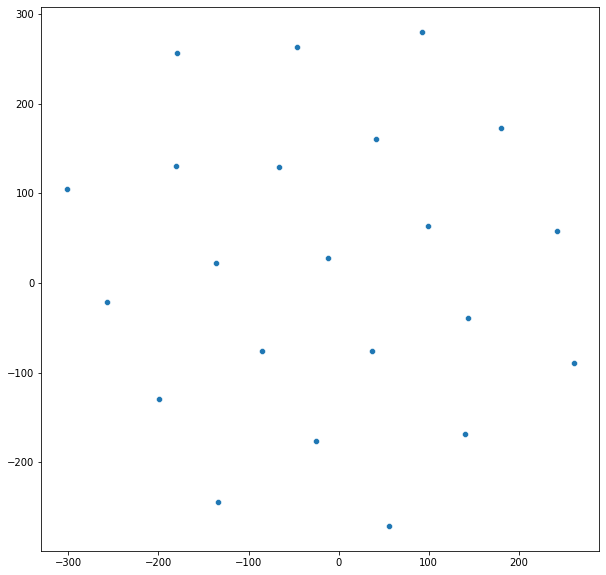

In [ ]:
#@title visualising gaussians' locations 
#@markdown gaussians seem to be displayed in a lattice 

mean_proj = TSNE().fit_transform(means)
plt.figure(figsize=(10, 10))
sns.scatterplot(x=mean_proj[:, 0], y=mean_proj[:, 1])

In [ ]:
experiment_params

{'auxiliary_prediction_task': True,
 'dropout': 0.2,
 'epochs': 1000,
 'hidden': 32,
 'latent_size': 16,
 'learning_rate': 0.001,
 'model': 'GM_VGAE',
 'save_path': 'data/saved/diseasome/model/',
 'use_features': True}

In [ ]:
# saves model

model.save_weights(experiment_params['save_path'])

## TODO 

In [ ]:
## TODO what is going on with roc and precision? train a simple gvae, see what happens 
## TODO generate save_path string from experiment params 
## TODO script for multiple training runs with different experiment params and checkpoint generation  
## TODO when we're sampling in the GMVGAE we might as well sample the elbo directly 